In [1]:
from typing import Callable

import numpy as np
import pandas as pd
from IPython.core.display import Markdown
from sklearn.model_selection import train_test_split

import notebooks.config as config
import notebooks.utils as nb_utils
from src.features.univariate_analysis import UACleaner
from src.utils import Dataset, Metadata, PipelineMetadata, preprocess_init

STAGE = 1
PREVIOUS_STAGE = STAGE - 1

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata in artifacts

In [2]:
def load_dataset_and_metadata() -> tuple[Dataset, Metadata]:
    df, metadata = nb_utils.load_artifacts(
        nb_utils.STAGES_DICT[PREVIOUS_STAGE]["name"],
        nb_utils.STAGES_DICT[PREVIOUS_STAGE]["folder_path"],
    )
    return df, metadata

In [3]:
df, metadata = load_dataset_and_metadata()

df.info(memory_usage="deep", max_cols=200)
print()

max_nans_for_rows = df.isna().sum(axis=1).max()
print(f"Max NaNs for rows: {max_nans_for_rows}")
print()

pd.options.display.max_rows = None

print("NaNs for cols")
nans_for_cols = nb_utils.get_nas(df)
display(nans_for_cols[nans_for_cols > 0])

pd.reset_option("display.max_rows", 0)

<class 'pandas.core.frame.DataFrame'>
Index: 29968 entries, 9249043 to 23246511
Data columns (total 168 columns):
 #    Column                                   Non-Null Count  Dtype         
---   ------                                   --------------  -----         
 0    name                                     29968 non-null  string        
 1    short_url                                29968 non-null  string        
 2    price                                    29968 non-null  UInt32        
 3    listing_followers_no                     27186 non-null  UInt16        
 4    location                                 29968 non-null  category      
 5    images_no                                29968 non-null  UInt8         
 6    description                              29968 non-null  string        
 7    gi_brand                                 29968 non-null  category      
 8    gi_model                                 29968 non-null  category      
 9    gi_production_year    

,missing count,missing [%]
ai_range_on_full_battery_km,29841,99.576215
gi_battery_capacity,29811,99.476108
ai_interest_free_credit,29782,99.379338
ai_cash_payment,29686,99.058996
ai_deposit,29496,98.424987
ai_installment_amount,29391,98.074613
ai_installment_no,29359,97.967832
ai_leasing,29182,97.377202
gi_certified,28454,94.947944
ai_credit,28152,93.940203


In [4]:
def train_test_split_nb(df: Dataset) -> tuple[Dataset, Dataset]:
    df_train, df_test = train_test_split(
        df,
        test_size=config.TEST_SIZE,
        random_state=config.RANDOM_SEED,
    )
    return df_train, df_test

In [5]:
df_orig = df
# Using alias for df_train for making things easier and more neat
df, df_test = train_test_split_nb(df)

In [6]:
n_rows_train, n_cols_train = df.shape

print("Train dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_train}")
print(f"No of cols: {n_cols_train}")

print()

n_rows_test, n_cols_test = df_test.shape

print("Test dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_test}")
print(f"No of cols: {n_cols_test}")
print(20 * "-")

Train dataset shape
--------------------
No of rows: 23974
No of cols: 168

Test dataset shape
--------------------
No of rows: 5994
No of cols: 168
--------------------


## Univariate Analysis

### nominal features

In [7]:
@preprocess_init
def ua_nominal_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for nominal features")
    for col in features_info["nominal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.loc[df.gi_body_type == "", "gi_body_type"] = np.nan
    print("Replaced ' ' category for 'gi_body_type' with NaN")

    df.gi_fuel_type = pd.Categorical(
        df.gi_fuel_type.astype("object").replace(
            {
                "Hibridni pogon (Benzin)": "Hibridni pogon",
                "Hibridni pogon (Dizel)": "Hibridni pogon",
                "Plug-in hibrid": "Hibridni pogon",
                "Metan CNG": "Benzin + Metan (CNG)",
            }
        ),
        ordered=False,
    )
    print("Grouped simillar categories for 'gi_fuel_type'")

    df.ai_gearbox_type = pd.Categorical(
        df.ai_gearbox_type.astype("object").replace(
            {
                "Automatski": "Automatski / poluautomatski",
                "Poluautomatski": "Automatski / poluautomatski",
            }
        )
    )
    print("Grouped simillar categories for 'ai_gearbox_type'")

    constant_strat_cols = [
        "ai_floating_flywheel",
        "ai_interior_material",
        "ai_interior_color",
        "ai_ownership",
        "ai_import_country",
        "ai_sales_method",
    ]
    modus_strat_cols = [
        col for col in features_info["nominal"] if col not in constant_strat_cols
    ]
    cols_nan_strategy["const_unknown"].extend(constant_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN constant strategy columns:")
    print(constant_strat_cols)
    print("Extended 'constant' and 'modus' cols_nan_strategy")

    return df, metadata

In [8]:
df, metadata = ua_nominal_features(df=df, metadata=metadata)

Frequencies for nominal features


,count,percentage [%]
location,,
Beograd,3965,16.538750
Novi Sad,1721,7.178610
Niš,988,4.121131
Kragujevac,891,3.716526
Čačak,747,3.115876
...,...,...
Jovanovac,1,0.004171
Jošanička Banja,1,0.004171
Jug Bogdanovac,1,0.004171


,count,percentage [%]
gi_brand,,
Volkswagen,3798,15.842162
Audi,2539,10.590640
BMW,2214,9.235005
Opel,1882,7.850171
Peugeot,1621,6.761492
...,...,...
Buick,1,0.004171
Wartburg,1,0.004171
Oldsmobile,1,0.004171


,count,percentage [%]
gi_model,,
A4,696,2.903145
A3,506,2.110620
Octavia,494,2.060566
A6,480,2.002169
Golf 7,450,1.877033
...,...,...
Quattro,1,0.004171
CLA 220 Shooting Brake,1,0.004171
CLA 250,1,0.004171


,count,percentage [%]
gi_body_type,,
Hečbek,8113,33.840828
Džip/SUV,4756,19.838158
Limuzina,4470,18.645199
Karavan,3670,15.308251
Monovolumen (MiniVan),1935,8.071244
Kupe,625,2.606991
Kabriolet/Roadster,247,1.030283
Pickup,156,0.650705
,2,0.008342


,count,percentage [%]
gi_fuel_type,,
Dizel,16395,68.386585
Benzin,5865,24.464003
Benzin + Gas (TNG),909,3.791608
Benzin + Metan (CNG),436,1.818637
Hibridni pogon,201,0.838408
Električni pogon,131,0.546425
Hibridni pogon (Benzin),21,0.087595
Hibridni pogon (Dizel),13,0.054225
Plug-in hibrid,2,0.008342


,count,percentage [%]
gi_trade_in,,
NE,17623,73.508801
DA,2982,12.438475
DA (za jeftinije),2250,9.385167
DA (za skuplje),773,3.224326
DA (u istoj ceni),346,1.443230


,count,percentage [%]
ai_floating_flywheel,,
NaN,16381,68.328189
Sa plivajućim zamajcem,4917,20.509719
Bez plivajućeg zamajca,2676,11.162092


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,8413,35.092183
Manuelni 6 brzina,8112,33.836656
Automatski / poluautomatski,7314,30.508050
Manuelni 4 brzine,118,0.492200
Automatski,15,0.062568
Poluautomatski,1,0.004171
NaN,1,0.004171


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,16313,68.044548
Manuelna klima,6897,28.768666
Nema klimu,764,3.186786


,count,percentage [%]
ai_color,,
Siva,7706,32.143155
Crna,6240,26.028197
Bela,3562,14.857763
Plava,2197,9.164094
Crvena,1087,4.534079
Teget,571,2.381747
Srebrna,569,2.373405
Braon,445,1.856178
Zelena,399,1.664303


,count,percentage [%]
ai_interior_material,,
Štof,12974,54.116960
Prirodna koža,4112,17.151915
NaN,3239,13.510470
Kombinovana koža,2908,12.129807
Drugi,380,1.585050
Velur,361,1.505798


,count,percentage [%]
ai_interior_color,,
Crna,12215,50.951030
Siva,4608,19.220823
NaN,4185,17.456411
Druga,1348,5.622758
Bež,1112,4.638358
Smeđa,506,2.110620


,count,percentage [%]
ai_propulsion,,
Prednji,17358,72.403437
4x4,4000,16.684742
Zadnji,2129,8.880454
4x4 reduktor,487,2.031367


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,14641,61.070326
Na ime kupca,9190,38.333194
Strane tablice,141,0.588137
NaN,2,0.008342


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,10251,42.758822
NaN,9356,39.025611
Ne vodi se na prodavca,4367,18.215567


,count,percentage [%]
ai_import_country,,
NaN,17909,74.701760
Švajcarska,1605,6.694753
Italija,1114,4.646701
Francuska,1007,4.200384
Nemačka,860,3.587219
Holandija,548,2.285810
Belgija,296,1.234671
Norveška,205,0.855093
Austrija,155,0.646534


,count,percentage [%]
ai_sales_method,,
NaN,21599,90.093435
Komisiona,2161,9.013932
Konsignaciona,214,0.892634


Dropped empty categories

Replaced ' ' category for 'gi_body_type' with NaN
Grouped simillar categories for 'gi_fuel_type'
Grouped simillar categories for 'ai_gearbox_type'
NaN constant strategy columns:
['ai_floating_flywheel', 'ai_interior_material', 'ai_interior_color', 'ai_ownership', 'ai_import_country', 'ai_sales_method']
Extended 'constant' and 'modus' cols_nan_strategy


### ordinal features

In [9]:
@preprocess_init
def ua_ordinal_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    print("Frequencies for ordinal features")
    for col in features_info["ordinal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.ai_damage = df.ai_damage.cat.reorder_categories(
        ["Nije oštećen", "Oštećen - u voznom stanju", "Oštećen - nije u voznom stanju"]
    )
    print("Corrected order of 'ai_damage' categories")

    modus_strat_cols = ["ai_engine_emission_class", "ai_damage"]
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN modus strategy columns:")
    print(modus_strat_cols)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

In [10]:
df, metadata = ua_ordinal_features(df=df, metadata=metadata)

Frequencies for ordinal features


,count,percentage [%]
ai_engine_emission_class,,
4,7161,29.869859
6,7154,29.840661
5,6629,27.650788
3,2516,10.494703
2,299,1.247184
1,209,0.871778
NaN,6,0.025027


,count,percentage [%]
ai_damage,,
Nije oštećen,23669,98.727788
Oštećen - u voznom stanju,183,0.763327
Oštećen - nije u voznom stanju,118,0.492200
NaN,4,0.016685


Dropped empty categories

Corrected order of 'ai_damage' categories
NaN modus strategy columns:
['ai_engine_emission_class', 'ai_damage']
Extended 'modus' cols_nan_strategy


### numerical features

In [11]:
@preprocess_init
def ua_numerical_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    idx_to_remove = metadata.idx_to_remove
    cols_nan_strategy = metadata.cols_nan_strategy

    for col in features_info["numerical"]:
        # display(Markdown("#### Feature 'images_no'"))
        nb_utils.show_hist_box_numerical_col(df, col)
        print()

    const_strat_cols_zero = ["listing_followers_no"]
    cols_scheduled_for_deletion = [
        "gi_battery_capacity",
        "ai_deposit",
        "ai_installment_no",
        "ai_cash_payment",
        "ai_range_on_full_battery_km",
    ]
    median_strat_cols = [
        col
        for col in features_info["numerical"]
        if col not in const_strat_cols_zero + cols_scheduled_for_deletion
    ]

    df_cars_with_0_kilometerage = df[df.gi_kilometerage == 0]
    print(f"Cars with 'gi_kilometerage' = 0: {df_cars_with_0_kilometerage.shape[0]}")

    df.drop(df_cars_with_0_kilometerage.index, inplace=True)
    idx_to_remove.extend(df_cars_with_0_kilometerage.index.to_list())
    print("Removed cars with 'gi_kilometerage' = 0")
    print()

    display(df.loc[df.gi_engine_capacity > 0.2 * 1e8])
    df.loc[df.gi_engine_capacity > 0.2 * 1e8, "gi_engine_capacity"] = np.nan
    print(
        "Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)"
    )
    print()

    print(
        "Cars where 'gi_production_year' = 2024: ",
        (df.gi_production_year == 2024).sum(),
    )
    print()

    listing_names_less_30_hp = df.loc[df.gi_engine_power < 30, "name"].values
    print(
        f"Listing names of cars where 'gi_engine_power' < 30 (horse power): {listing_names_less_30_hp}"
    )
    print()

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)
    print("Dropped 'gi_battery_capacity' (too many zero values)")
    print("Dropped 'ai_deposit' (label leakage)")
    print("Dropped 'ai_installment_no' (label leakage)")
    print("Dropped 'ai_cash_payment' (label leakage)")
    print("Dropped 'ai_range_on_full_battery_km' (too many zero values)")

    cols_nan_strategy["const_0"].extend(const_strat_cols_zero)
    cols_nan_strategy["median"].extend(median_strat_cols)
    print("NaN fill by 0 strategy columns:")
    print(const_strat_cols_zero)
    print("Extended 'modus' cols_nan_strategy")

    return df, metadata

Univariate analysis of 'listing_followers_no' column
Histogram and box plot


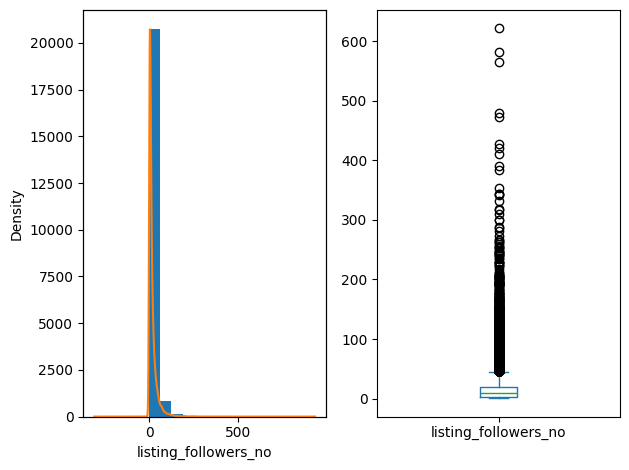

Descriptive statistics


count      21759.0
mean     17.364539
std      27.148723
min            1.0
25%            3.0
50%            9.0
75%           20.0
max          621.0
Name: listing_followers_no, dtype: Float64

Variance: 1.56345775346883
Skewness: 5.902412670055126
Kurtosis: 66.31693722715019

NA values
Count [n]: 2215
Percentage [%]: 9.239175773754901%

Univariate analysis of 'images_no' column
Histogram and box plot


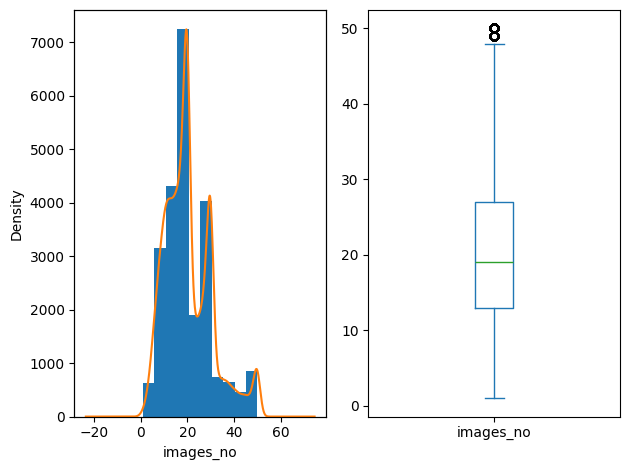

Descriptive statistics


count      23974.0
mean     20.455201
std      10.167068
min            1.0
25%           13.0
50%           19.0
75%           27.0
max           50.0
Name: images_no, dtype: Float64

Variance: 0.4970407003006165
Skewness: 0.8705524987333942
Kurtosis: 0.649809555847479

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_kilometerage' column
Histogram and box plot


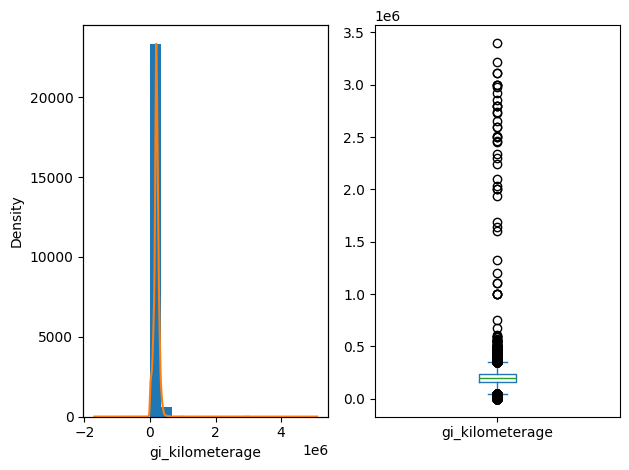

Descriptive statistics


count          23974.0
mean     198141.094686
std      116485.846133
min                1.0
25%           160000.0
50%           195000.0
75%           235000.0
max          3400009.0
Name: gi_kilometerage, dtype: Float64

Variance: 0.5878934216919642
Skewness: 13.082068792716177
Kurtosis: 286.0418975731726

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_production_year' column
Histogram and box plot


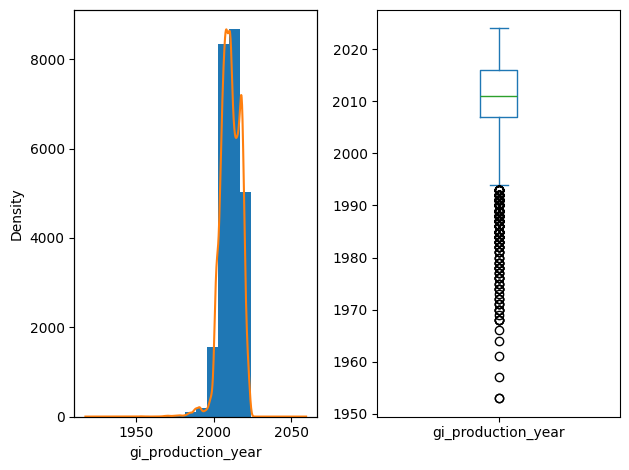

Descriptive statistics


count        23974.0
mean     2010.684575
std         6.317246
min           1953.0
25%           2007.0
50%           2011.0
75%           2016.0
max           2024.0
Name: gi_production_year, dtype: Float64

Variance: 0.0031418382849965456
Skewness: -0.9011205200450996
Kurtosis: 3.533818868574949

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_engine_capacity' column
Histogram and box plot


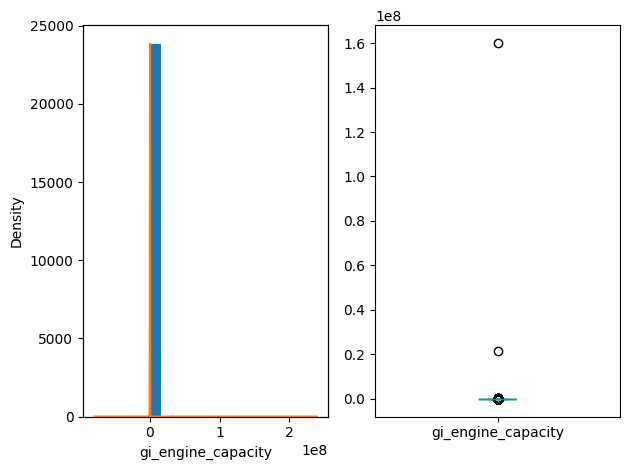

Descriptive statistics


count           23843.0
mean        9464.353269
std      1045806.094536
min               105.0
25%              1461.0
50%              1798.0
75%              1993.0
max         160051414.0
Name: gi_engine_capacity, dtype: Float64

Variance: 110.49947785954512
Skewness: 150.6822444291252
Kurtosis: 23008.60449065838

NA values
Count [n]: 131
Percentage [%]: 0.5464252940685743%

Univariate analysis of 'gi_engine_power' column
Histogram and box plot


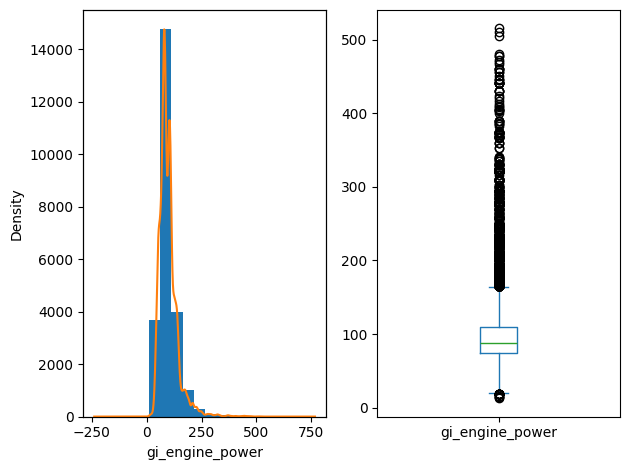

Descriptive statistics


count    23974.000000
mean        98.516184
std         42.914438
min         13.000000
25%         74.000000
50%         88.000000
75%        110.000000
max        515.000000
Name: gi_engine_power, dtype: float64

Variance: 0.4356080003897612
Skewness: 2.560411031056466
Kurtosis: 12.557656434646807

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_battery_capacity' column
Histogram and box plot


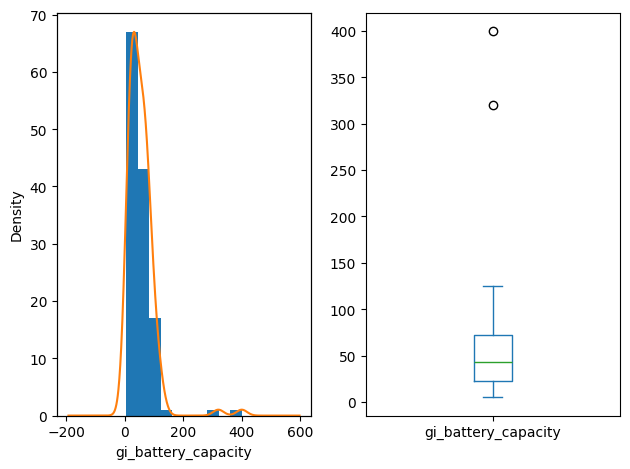

Descriptive statistics


count        130.0
mean     54.162308
std      48.298695
min            5.0
25%           23.0
50%           43.0
75%           72.3
max          400.0
Name: gi_battery_capacity, dtype: Float64

Variance: 0.8917399725817726
Skewness: 4.162981059929363
Kurtosis: 24.992511832482357

NA values
Count [n]: 23844
Percentage [%]: 99.45774589138233%

Univariate analysis of 'ai_seats_no' column
Histogram and box plot


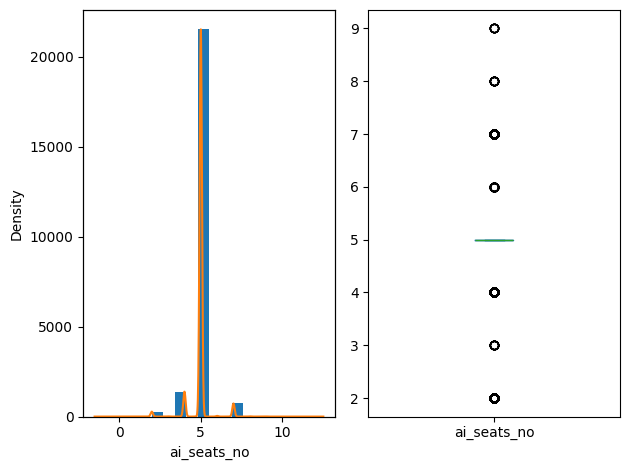

Descriptive statistics


count     23974.0
mean     4.971719
std      0.542247
min           2.0
25%           5.0
50%           5.0
75%           5.0
max           9.0
Name: ai_seats_no, dtype: Float64

Variance: 0.10906630191077704
Skewness: -0.43363882596825615
Kurtosis: 15.32897362226311

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'ai_deposit' column
Histogram and box plot


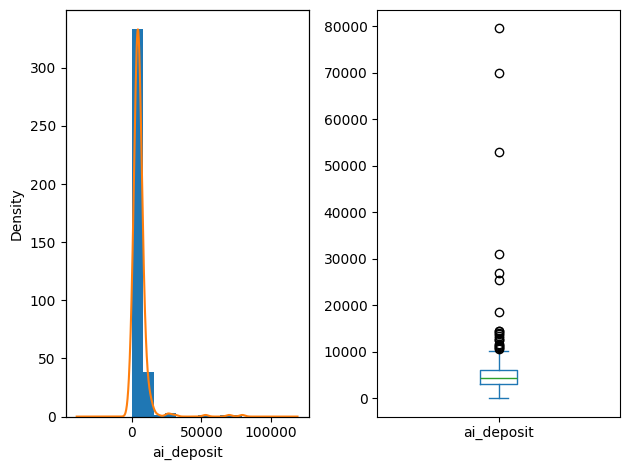

Descriptive statistics


count          378.0
mean     5409.910053
std       6621.94407
min              1.0
25%           3138.0
50%           4380.0
75%           6000.0
max          79480.0
Name: ai_deposit, dtype: Float64

Variance: 1.2240395875628518
Skewness: 7.504456072942155
Kurtosis: 71.06289174241122

NA values
Count [n]: 23596
Percentage [%]: 98.42329189955785%

Univariate analysis of 'ai_installment_no' column
Histogram and box plot


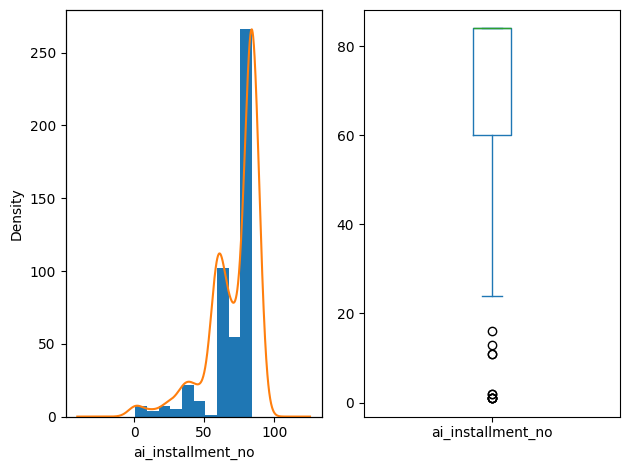

Descriptive statistics


count       480.0
mean     71.15625
std      18.14102
min           1.0
25%          60.0
50%          84.0
75%          84.0
max          84.0
Name: ai_installment_no, dtype: Float64

Variance: 0.2549462680193397
Skewness: -1.6577522846205703
Kurtosis: 2.774926121808095

NA values
Count [n]: 23494
Percentage [%]: 97.99783098356552%

Univariate analysis of 'ai_installment_amount' column
Histogram and box plot


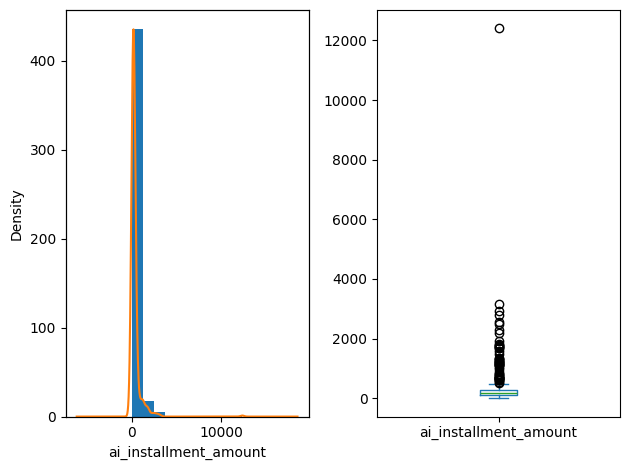

Descriptive statistics


count         458.0
mean     333.855895
std      708.869712
min             1.0
25%           118.5
50%           173.5
75%          268.75
max         12400.0
Name: ai_installment_amount, dtype: Float64

Variance: 2.1232804985699576
Skewness: 11.57453093235109
Kurtosis: 183.40561828043056

NA values
Count [n]: 23516
Percentage [%]: 98.08959706348544%

Univariate analysis of 'ai_cash_payment' column
Histogram and box plot


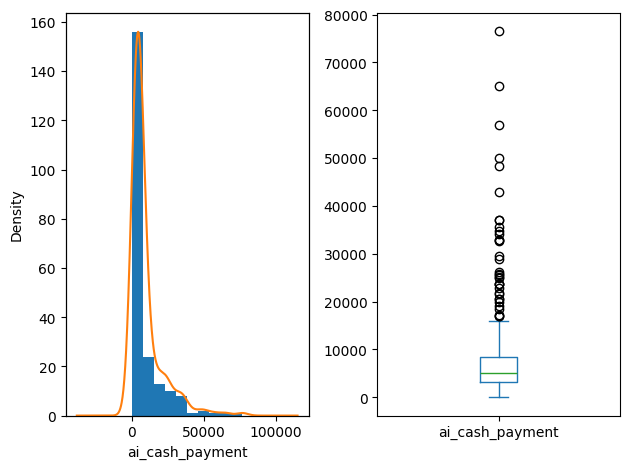

Descriptive statistics


count           217.0
mean      9173.488479
std      11488.823098
min               1.0
25%            3150.0
50%            5000.0
75%            8490.0
max           76600.0
Name: ai_cash_payment, dtype: Float64

Variance: 1.2523941272682808
Skewness: 2.81785524708441
Kurtosis: 9.437820588704886

NA values
Count [n]: 23757
Percentage [%]: 99.09485275715359%

Univariate analysis of 'ai_range_on_full_battery_km' column
Histogram and box plot


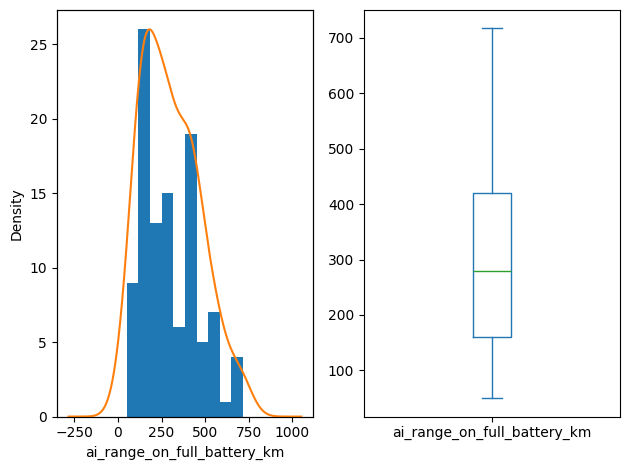

Descriptive statistics


count         105.0
mean     300.352381
std      164.411011
min            50.0
25%           160.0
50%           280.0
75%           420.0
max           717.0
Name: ai_range_on_full_battery_km, dtype: Float64

Variance: 0.5473937315488442
Skewness: 0.5527147524820483
Kurtosis: -0.41282565422075423

NA values
Count [n]: 23869
Percentage [%]: 99.56202552765497%

Cars with 'gi_kilometerage' = 0: 0
Removed cars with 'gi_kilometerage' = 0



,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Garažiran,o_Kupljen_nov_u_Srbiji,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Test_vozilo,o_Tuning
id,,,,,,,,,,,,,,,,,,,,,
22503872,Mercedes Benz E 200 CDi Classic,https://www.polovniautomobili.com/auto-oglasi/...,4500,6,Čačak,20,Uslužna prodaja- Vozilo se nalazi kod nas Polo...,Mercedes Benz,E 200,2004,...,False,False,False,False,False,False,True,False,False,False
23210877,Opel Insignia EXCLUSIVE,https://www.polovniautomobili.com/auto-oglasi/...,15200,4,Leštane,30,Opel Insignija 1.6D 136 KS 6 brz. Auto je u na...,Opel,Insignia,2019,...,True,False,False,False,False,False,True,True,False,False


Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)

Cars where 'gi_production_year' = 2024:  5

Listing names of cars where 'gi_engine_power' < 30 (horse power): <StringArray>
[ 'Zastava 750 presla 38.400',            'Zastava 750 750',
            'Renault R 4 GTL',             'Zastava 750 LE',
                'Zastava 750',           'Fiat 126 Peglica',
               'ZhiDou Icaro',              'Renault Twizy',
   'Citroen Ami ami electric',      'Zastava 750 LE sa Reg',
             'Zastava 750 LE',                'Trabant 601',
          'Fiat Seicento 0.9',      'Volkswagen Buba 1200J',
                'Zastava 750',                'Opel Kadett',
 'Renault Twizy elektro  8kw',          'Suzuki Maruti 800',
                'Zastava 750',          'Fiat 500L Berlina',
           'Renault R 4 1100',              'Renault Twizy',
     'Renault Twizy eletktro',           'Fiat Cinquecento',
                'Trabant 601',            'Renault R 4 G

In [12]:
df, metadata = ua_numerical_features(df=df, metadata=metadata)

### binary features

In [13]:
@preprocess_init
def ua_binary_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    display(Markdown("### Categories for every binary column"))
    for col in features_info["binary"]:
        display(nb_utils.get_value_counts_freq_with_perc(df, col))

    cols_scheduled_for_deletion = [
        "e_Fabrički_ugrađeno_dečije_sedište",
        "e_Volan_u_kombinaciji_drvo_ili_koža",
        "o_Oldtimer",
        "o_Prilagođeno_invalidima",
        "o_Restauriran",
        "o_Test_vozilo",
        "o_Tuning",
    ]
    print(f"Columns scheduled for deletion:\n{cols_scheduled_for_deletion}")
    print()

    const_false_strat_cols = ["ai_credit", "ai_interest_free_credit", "ai_leasing"]
    modus_strat_cols = [
        col
        for col in features_info["binary"]
        if col not in cols_scheduled_for_deletion + const_false_strat_cols
    ]
    print("NaN fill by False strategy columns:")
    print(const_false_strat_cols)
    print()

    cols_nan_strategy["const_false"].extend(const_false_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("Extended 'const_false' and 'modus' cols_nan_strategy")

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)

    return df, metadata

In [14]:
df, metadata = ua_binary_features(df=df, metadata=metadata)

### Categories for every binary column

,count,percentage [%]
s_ABS,,
True,22244,92.783849
False,1730,7.216151


,count,percentage [%]
s_ASR,,
True,17303,72.174022
False,6671,27.825978


,count,percentage [%]
s_Airbag_za_suvozača,,
True,22389,93.388671
False,1585,6.611329


,count,percentage [%]
s_Airbag_za_vozača,,
True,22532,93.985151
False,1442,6.014849


,count,percentage [%]
s_Alarm,,
False,17403,72.59114
True,6571,27.40886


,count,percentage [%]
s_Asistencija_praćenja_trake,,
False,20514,85.567698
True,3460,14.432302


,count,percentage [%]
s_Automatsko_kočenje,,
False,20319,84.754317
True,3655,15.245683


,count,percentage [%]
s_Blokada_motora,,
False,17443,72.757988
True,6531,27.242012


,count,percentage [%]
s_Bočni_airbag,,
True,20759,86.589639
False,3215,13.410361


,count,percentage [%]
s_Centralno_zaključavanje,,
True,22038,91.924585
False,1936,8.075415


,count,percentage [%]
s_Child_lock,,
True,13372,55.777092
False,10602,44.222908


,count,percentage [%]
s_ESP,,
True,18328,76.449487
False,5646,23.550513


,count,percentage [%]
s_Kodiran_ključ,,
True,15167,63.26437
False,8807,36.73563


,count,percentage [%]
s_Mehanička_zaštita,,
False,22504,93.868357
True,1470,6.131643


,count,percentage [%]
s_OBD_zaštita,,
False,19357,80.741637
True,4617,19.258363


,count,percentage [%]
s_Senzor_mrtvog_ugla,,
False,21941,91.51998
True,2033,8.48002


,count,percentage [%]
s_Ulazak_bez_ključa,,
False,20109,83.878368
True,3865,16.121632


,count,percentage [%]
s_Vazdušni_jastuci_za_kolena,,
False,18955,79.06482
True,5019,20.93518


,count,percentage [%]
e_360_kamera,,
False,23072,96.237591
True,902,3.762409


,count,percentage [%]
e_AUX_konekcija,,
False,13755,57.374656
True,10219,42.625344


,count,percentage [%]
e_Adaptivna_svetla,,
False,19248,80.286978
True,4726,19.713022


,count,percentage [%]
e_Adaptivni_tempomat,,
False,20510,85.551014
True,3464,14.448986


,count,percentage [%]
e_Aluminijumske_felne,,
True,16983,70.839243
False,6991,29.160757


,count,percentage [%]
e_Ambijentalno_osvetljenje,,
False,20652,86.143322
True,3322,13.856678


,count,percentage [%]
e_Android_Auto,,
False,21515,89.743055
True,2459,10.256945


,count,percentage [%]
e_Apple_CarPlay,,
False,21567,89.959957
True,2407,10.040043


,count,percentage [%]
e_Asistencija_za_kretanje_na_uzbrdici,,
False,15292,63.785768
True,8682,36.214232


,count,percentage [%]
e_Automatsko_parkiranje,,
False,22251,92.813047
True,1723,7.186953


,count,percentage [%]
e_Automatsko_zatamnjivanje_retrovizora,,
False,17202,71.752732
True,6772,28.247268


,count,percentage [%]
e_Autonomna_vožnja,,
False,23050,96.145825
True,924,3.854175


,count,percentage [%]
e_Bluetooth,,
False,13121,54.730124
True,10853,45.269876


,count,percentage [%]
e_Branici_u_boji_auta,,
True,15453,64.457329
False,8521,35.542671


,count,percentage [%]
e_Brisači_prednjih_farova,,
False,21730,90.63986
True,2244,9.36014


,count,percentage [%]
e_CD_changer,,
False,20876,87.077667
True,3098,12.922333


,count,percentage [%]
e_DPF_filter,,
False,14104,58.8304
True,9870,41.1696


,count,percentage [%]
e_DVD_ili_TV,,
False,21612,90.14766
True,2362,9.85234


,count,percentage [%]
e_Daljinsko_zaključavanje,,
True,20301,84.679236
False,3673,15.320764


,count,percentage [%]
e_Digitalni_radio,,
False,18633,77.721699
True,5341,22.278301


,count,percentage [%]
e_Dnevna_svetla,,
True,12580,52.473513
False,11394,47.526487


,count,percentage [%]
e_Držači_za_čaše,,
True,18446,76.941687
False,5528,23.058313


,count,percentage [%]
e_Ekran_na_dodir,,
False,17876,74.564111
True,6098,25.435889


,count,percentage [%]
e_Električni_podizači,,
True,21898,91.340619
False,2076,8.659381


,count,percentage [%]
e_Električni_retrovizori,,
True,20373,84.979561
False,3601,15.020439


,count,percentage [%]
e_Elektro_otvaranje_prtljažnika,,
False,13838,57.720864
True,10136,42.279136


,count,percentage [%]
e_Elektro_podesiva_sedišta,,
False,18494,77.141904
True,5480,22.858096


,count,percentage [%]
e_Elektro_sklopivi_retrovizori,,
False,17189,71.698507
True,6785,28.301493


,count,percentage [%]
e_Elektro_zatvaranje_prtljažnika,,
False,21845,91.119546
True,2129,8.880454


,count,percentage [%]
e_Elektronska_ručna_kočnica,,
False,16674,69.550346
True,7300,30.449654


,count,percentage [%]
e_Fabrički_ugrađeno_dečije_sedište,,
False,23883,99.620422
True,91,0.379578


,count,percentage [%]
e_Glasovne_komande,,
False,19623,81.851172
True,4351,18.148828


,count,percentage [%]
e_Grejanje_sedišta,,
False,17571,73.2919
True,6403,26.7081


,count,percentage [%]
e_Grejanje_volana,,
False,23143,96.533745
True,831,3.466255


,count,percentage [%]
e_Grejači_retrovizora,,
True,17872,74.547426
False,6102,25.452574


,count,percentage [%]
e_Grejači_vetrobranskog_stakla,,
False,19278,80.412113
True,4696,19.587887


,count,percentage [%]
e_Hands_free,,
False,16570,69.116543
True,7404,30.883457


,count,percentage [%]
e_Hard_disk,,
False,22310,93.059147
True,1664,6.940853


,count,percentage [%]
e_Head_up_display,,
False,23059,96.183365
True,915,3.816635


,count,percentage [%]
e_ISOFIX_sistem,,
True,17245,71.932093
False,6729,28.067907


,count,percentage [%]
e_Indikator_niskog_pritiska_u_gumama,,
False,14161,59.068157
True,9813,40.931843


,count,percentage [%]
e_Kamera,,
False,20070,83.715692
True,3904,16.284308


,count,percentage [%]
e_Keramičke_kočnice,,
False,23762,99.115709
True,212,0.884291


,count,percentage [%]
e_Kožni_volan,,
True,15478,64.561608
False,8496,35.438392


,count,percentage [%]
e_Krovni_nosač,,
False,17784,74.180362
True,6190,25.819638


,count,percentage [%]
e_Kuka_za_vuču,,
False,21342,89.02144
True,2632,10.97856


,count,percentage [%]
e_LED_prednja_svetla,,
False,15958,66.563777
True,8016,33.436223


,count,percentage [%]
e_LED_zadnja_svetla,,
False,16030,66.864103
True,7944,33.135897


,count,percentage [%]
e_MP3,,
False,13331,55.606073
True,10643,44.393927


,count,percentage [%]
e_Masažna_sedišta,,
False,23358,97.43055
True,616,2.56945


,count,percentage [%]
e_Matrix_farovi,,
False,22718,94.760991
True,1256,5.239009


,count,percentage [%]
e_Memorija_sedišta,,
False,22349,93.221824
True,1625,6.778176


,count,percentage [%]
e_Metalik_boja,,
True,13896,57.962793
False,10078,42.037207


,count,percentage [%]
e_Modovi_vožnje,,
False,19623,81.851172
True,4351,18.148828


,count,percentage [%]
e_Multifunkcionalni_volan,,
True,15476,64.553266
False,8498,35.446734


,count,percentage [%]
e_Multimedija,,
False,14474,60.373738
True,9500,39.626262


,count,percentage [%]
e_Naslon_za_ruku,,
True,15411,64.282139
False,8563,35.717861


,count,percentage [%]
e_Navigacija,,
False,15258,63.643948
True,8716,36.356052


,count,percentage [%]
e_Ostava_sa_hlađenjem,,
False,16043,66.918328
True,7931,33.081672


,count,percentage [%]
e_Otvor_za_skije,,
False,20706,86.368566
True,3268,13.631434


,count,percentage [%]
e_Paljenje_bez_ključa,,
False,18769,78.28898
True,5205,21.71102


,count,percentage [%]
e_Panorama_krov,,
False,21963,91.611746
True,2011,8.388254


,count,percentage [%]
e_Parking_senzori,,
False,12812,53.441228
True,11162,46.558772


,count,percentage [%]
e_Podešavanje_volana_po_visini,,
True,19380,80.837574
False,4594,19.162426


,count,percentage [%]
e_Postolje_za_bežično_punjenje_telefona,,
False,23015,95.999833
True,959,4.000167


,count,percentage [%]
e_Prednja_noćna_kamera,,
False,23612,98.490031
True,362,1.509969


,count,percentage [%]
e_Privlačenje_vrata_pri_zatvaranju,,
False,23489,97.976975
True,485,2.023025


,count,percentage [%]
e_Putni_računar,,
True,18732,78.134646
False,5242,21.865354


,count,percentage [%]
e_Radio_CD,,
True,16888,70.44298
False,7086,29.55702


,count,percentage [%]
e_Radio_ili_Kasetofon,,
True,13625,56.832402
False,10349,43.167598


,count,percentage [%]
e_Retrovizor_se_obara_pri_rikvercu,,
False,21150,88.220572
True,2824,11.779428


,count,percentage [%]
e_Rezervni_točak,,
False,12488,52.089764
True,11486,47.910236


,count,percentage [%]
e_Ručice_za_menjanje_brzina_na_volanu,,
False,21167,88.291482
True,2807,11.708518


,count,percentage [%]
e_Sedišta_podesiva_po_visini,,
True,16570,69.116543
False,7404,30.883457


,count,percentage [%]
e_Senzori_za_kišu,,
True,12627,52.669559
False,11347,47.330441


,count,percentage [%]
e_Senzori_za_svetla,,
True,12005,50.075081
False,11969,49.924919


,count,percentage [%]
e_Servo_volan,,
True,22441,93.605573
False,1533,6.394427


,count,percentage [%]
e_Sportska_sedišta,,
False,19446,81.112872
True,4528,18.887128


,count,percentage [%]
e_Sportsko_vešanje,,
False,21821,91.019438
True,2153,8.980562


,count,percentage [%]
e_Start_stop_sistem,,
False,17546,73.18762
True,6428,26.81238


,count,percentage [%]
e_Subwoofer,,
False,22347,93.213481
True,1627,6.786519


,count,percentage [%]
e_Svetla_za_maglu,,
True,17525,73.100025
False,6449,26.899975


,count,percentage [%]
e_Tempomat,,
True,14853,61.954618
False,9121,38.045382


,count,percentage [%]
e_Tonirana_stakla,,
True,18639,77.746726
False,5335,22.253274


,count,percentage [%]
e_Torba_za_skije,,
False,23621,98.527572
True,353,1.472428


,count,percentage [%]
e_USB,,
False,14135,58.959706
True,9839,41.040294


,count,percentage [%]
e_Upravljanje_na_sva_četiri_točka,,
False,23144,96.537916
True,830,3.462084


,count,percentage [%]
e_Utičnica_od_12V,,
True,16529,68.945524
False,7445,31.054476


,count,percentage [%]
e_Vazdušno_vešanje,,
False,23167,96.633853
True,807,3.366147


,count,percentage [%]
e_Ventilacija_sedišta,,
False,23477,97.926921
True,497,2.073079


,count,percentage [%]
e_Virtuelna_tabla,,
False,22342,93.192625
True,1632,6.807375


,count,percentage [%]
e_Volan_u_kombinaciji_drvo_ili_koža,,
False,23835,99.420205
True,139,0.579795


,count,percentage [%]
e_Webasto,,
False,23166,96.629682
True,808,3.370318


,count,percentage [%]
e_Xenon_svetla,,
False,18261,76.170018
True,5713,23.829982


,count,percentage [%]
e_Zaključavanje_diferencijala,,
False,23217,96.842413
True,757,3.157587


,count,percentage [%]
e_Zavesice_na_zadnjim_prozorima,,
False,22999,95.933094
True,975,4.066906


,count,percentage [%]
e_Šiber,,
False,22419,93.513807
True,1555,6.486193


,count,percentage [%]
o_Garancija,,
False,17847,74.443147
True,6127,25.556853


,count,percentage [%]
o_Garažiran,,
False,14487,60.427964
True,9487,39.572036


,count,percentage [%]
o_Kupljen_nov_u_Srbiji,,
False,21754,90.739968
True,2220,9.260032


,count,percentage [%]
o_Oldtimer,,
False,23907,99.720531
True,67,0.279469


,count,percentage [%]
o_Prilagođeno_invalidima,,
False,23968,99.974973
True,6,0.025027


,count,percentage [%]
o_Prvi_vlasnik,,
False,19380,80.837574
True,4594,19.162426


,count,percentage [%]
o_Restauriran,,
False,23923,99.78727
True,51,0.21273


,count,percentage [%]
o_Rezervni_ključ,,
False,12062,50.312839
True,11912,49.687161


,count,percentage [%]
o_Servisna_knjiga,,
False,13509,56.348544
True,10465,43.651456


,count,percentage [%]
o_Test_vozilo,,
False,23907,99.720531
True,67,0.279469


,count,percentage [%]
o_Tuning,,
False,23840,99.441061
True,134,0.558939


,count,percentage [%]
ai_doors_no,,
True,21530,89.805623
False,2442,10.186035
<NA>,2,0.008342


,count,percentage [%]
ai_credit,,
<NA>,22524,93.951781
True,1450,6.048219


,count,percentage [%]
ai_interest_free_credit,,
<NA>,23834,99.416034
True,140,0.583966


,count,percentage [%]
ai_leasing,,
<NA>,23361,97.443063
True,613,2.556937


Columns scheduled for deletion:
['e_Fabrički_ugrađeno_dečije_sedište', 'e_Volan_u_kombinaciji_drvo_ili_koža', 'o_Oldtimer', 'o_Prilagođeno_invalidima', 'o_Restauriran', 'o_Test_vozilo', 'o_Tuning']

NaN fill by False strategy columns:
['ai_credit', 'ai_interest_free_credit', 'ai_leasing']

Extended 'const_false' and 'modus' cols_nan_strategy


### other features

In [15]:
@preprocess_init
def ua_other_features(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info
    cols_nan_strategy = metadata.cols_nan_strategy

    # Subset of other columns
    other_columns = ["gi_certified", "ai_registered_until"]

    display(Markdown("### Descriptive statistics of other columns"))
    display(df[other_columns].describe())
    print("Missing values of other columns")
    nb_utils.get_nas(df[other_columns])  # type: ignore

    today_date = np.datetime64("2024-01")

    df.gi_certified = pd.to_numeric(
        (df.gi_certified - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    df.ai_registered_until = pd.to_numeric(
        (df.ai_registered_until - today_date).dt.days.astype("Int64"),  # type: ignore
        downcast="signed",
    )
    print(
        "Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates"
    )
    print()

    display(Markdown("### Univariate analysis of transformed other columns"))
    for col in other_columns:
        nb_utils.show_hist_box_numerical_col(df, col)
    print()

    cols_nan_strategy["const_0"].extend(other_columns)
    print("NaN constant 0 strategy columns:")
    print(other_columns)

    for col in other_columns:
        features_info["other"].remove(col)
    print(f"Removed {other_columns} from other features")

    features_info["numerical"].extend(other_columns)
    print(f"Added {other_columns} to numerical features")

    return df, metadata

### Descriptive statistics of other columns

,gi_certified,ai_registered_until
count,1208,13607
mean,2027-01-11 11:56:25.430463744,2024-07-08 10:45:13.956051968
min,2022-05-01 00:00:00,2021-06-01 00:00:00
25%,2025-10-01 00:00:00,2024-04-01 00:00:00
50%,2027-03-01 00:00:00,2024-07-01 00:00:00
75%,2028-01-01 00:00:00,2024-10-01 00:00:00
max,2033-11-01 00:00:00,2025-03-01 00:00:00


Missing values of other columns
Transformed 'gi_certified' and 'ai_registered_until' to difference of '2024-01' date and corresponding dates



### Univariate analysis of transformed other columns

Univariate analysis of 'gi_certified' column
Histogram and box plot


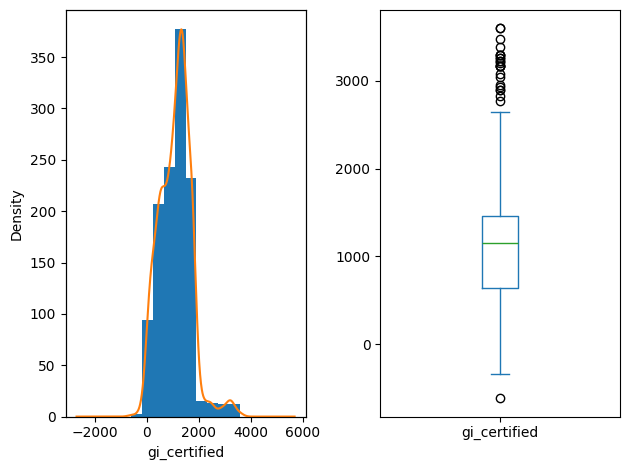

Descriptive statistics


count         1208.0
mean     1106.497517
std       608.299879
min           -610.0
25%            639.0
50%           1155.0
75%           1461.0
max           3592.0
Name: gi_certified, dtype: Float64

Variance: 0.5497525927704612
Skewness: 0.5250921405276685
Kurtosis: 1.3329214157020512

NA values
Count [n]: 22766
Percentage [%]: 94.96120797530658%
Univariate analysis of 'ai_registered_until' column
Histogram and box plot


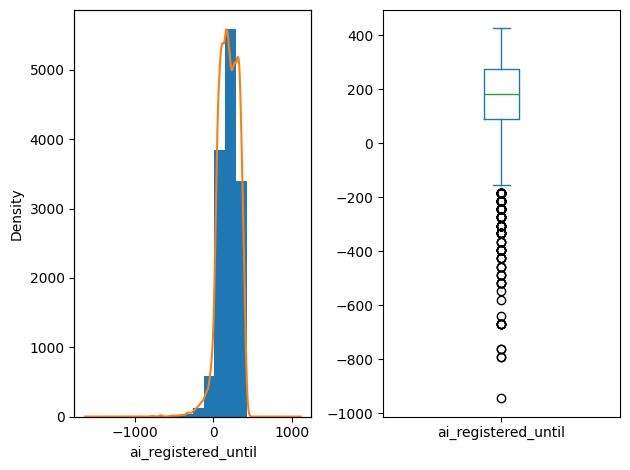

Descriptive statistics


count       13607.0
mean     189.448078
std       127.07874
min          -944.0
25%            91.0
50%           182.0
75%           274.0
max           425.0
Name: ai_registered_until, dtype: Float64

Variance: 0.6707840035829096
Skewness: -0.9548869492745656
Kurtosis: 3.4907902063792173

NA values
Count [n]: 10367
Percentage [%]: 43.24267956953366%

NaN constant 0 strategy columns:
['gi_certified', 'ai_registered_until']
Removed ['gi_certified', 'ai_registered_until'] from other features
Added ['gi_certified', 'ai_registered_until'] to numerical features


In [16]:
df, metadata = ua_other_features(df=df, metadata=metadata)

## Testing

### Test individual components

In [17]:
def get_func_from_globals(func: Callable) -> Callable:
    result_func_name: str = func.__name__
    result_func: Callable = globals()[result_func_name]

    if not callable(result_func):
        raise Exception(
            f"Provided function {func.__name__} is not a function in globals."
        )
    return result_func


class TestNotebook(nb_utils.TestNotebookGeneric):
    # Testing only df_train
    def test_single_funcs(self):
        transf_obj: UACleaner = self.transformer_obj  # type: ignore

        df_prep, metadata_prep = load_dataset_and_metadata()
        # Get df_train
        df_prep, _ = train_test_split_nb(df)

        all_funcs_to_test: list[Callable] = [
            transf_obj.ua_nominal_features,
            transf_obj.ua_ordinal_features,
            transf_obj.ua_numerical_features,
            transf_obj.ua_binary_features,
        ]

        for func_to_test in all_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep,
                metadata=metadata_prep,
            )

    def test_whole_component(self, df_nb: Dataset, metadata_nb: Metadata):
        df_init_py, metadata_init_py = load_dataset_and_metadata()
        df_init_py, _ = train_test_split_nb(df_init_py)
        self._test_whole_component_complex(
            df_init_py, metadata_init_py, df_nb, metadata_nb
        )

In [ ]:
test_obj = TestNotebook(UACleaner(PipelineMetadata()))
test_obj.test_single_funcs()

### Test whole component

In [19]:
test_obj.test_whole_component(df_nb=df, metadata_nb=metadata)

## Save cleaned data and metadata in artifacts

In [20]:
nb_utils.save_artifacts(
    nb_utils.STAGES_DICT[STAGE]["name"],
    nb_utils.STAGES_DICT[STAGE]["folder_path"],
    df,
    metadata,
)